<a href="https://colab.research.google.com/github/kvong/DeepLearning-NeuralStyleTransfer/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
! cp -r drive/My\ Drive/boat.jpg drive/My\ Drive/beautifulnight.jpg ./ 
! ls

beautifulnight.jpg  boat.jpg  drive  sample_data


In [0]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

target_image_path = './boat.jpg'
style_image_path = './beautifulnight.jpg'

width, height = load_img(target_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows/ height)

In [0]:
import numpy as np
from tensorflow.keras.applications import vgg19

def preprocess_image(image_path):
  img = load_img(image_path, target_size=(img_nrows, img_ncols))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return img

def deprocess_image(x):
  if K.image_data_format() == 'channels_first':
    x = x.reshape((3, img_nrows, img_ncols))
    x = x.transpose((1, 2, 0))
  else:
    x = x.reshape((img_nrows, img_ncols, 3))
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x



In [19]:
from tensorflow.keras import backend as K

base_image = K.variable(preprocess_image(target_image_path))
style_image = K.variable(preprocess_image(style_image_path))

if K.image_data_format() == 'channels_first':
  combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
  combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

input_tensor = K.concatenate([base_image,
                              style_image,
                              combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)                              
print('Model loaded.')                    

Model loaded.


In [0]:
def content_loss(base, combination):
  return K.sum(K.square(combination - base))

def gram_matrix(x):
  assert K.ndim(x) == 3
  if K.image_data_format() == 'channels_first':
    features = K.batch_flatten(x)
  else:
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
  gram = K.dot(features, K.transpose(features))
  return gram

def style_loss(style, combination):
  assert K.ndim(style) == 3
  assert K.ndim(combination) == 3
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_nrows * img_ncols
  return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
  assert K.ndim(x) == 4
  if K.image_data_format() == 'channels_first':
    a = K.square(
        x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
    b = K.square(
        x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
  else:
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
  return K.sum(K.pow(a + b, 1.125))

In [0]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
               'block2_conv1',
               'block3_conv1',
               'block4_conv1',
               'block5_conv1']

total_variation_weight = 1e-4
style_weight = 1.               
content_weight = 0.025

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + (content_weight * content_loss(target_image_features, combination_features))
for layer_name in style_layers:
  layer_features = outputs_dict[layer_name] 
  style_reference_features = layer_features[1, :, :, :]
  combination_features = layer_features[2, :, :, :]
  sl = style_loss(style_reference_features, combination_features)
  loss = loss + ((style_weight / len(style_layers)) * sl)

loss = loss + (total_variation_weight * total_variation_loss(combination_image))

In [0]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
  outputs += grads
else:
  outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

def eval_loss_and_grads(x):
  if K.image_data_format() == 'channels_first':
    x = x.reshape((1, 3, img_nrows, img_ncols))
  else:
    x = x.reshape((1, img_nrows, img_ncols, 3))
  outs = f_outputs([x])
  loss_value = outs[0]
  if len(outs[1:]) == 1:
    grad_values = outs[1].flatten().astype('float64')
  else:
    grad_values = np.array(outs[1:]).flatten().astype('float64')
  return loss_value, grad_values

class Evaluator(object):
  def __init__(self):
    self.loss_value = None
    self.grad_values = None

  def loss(self, x):
    assert self.loss_value is None
    loss_value, grad_values = eval_loss_and_grads(x)
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value
    
  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values

In [0]:
from PIL import Image
import matplotlib.pyplot as plt

def show_image(name):
  image = Image.open(name)
  plt.imshow(image)
  plt.show()

Start of iteration:  0
Current loss:  1559635200.0


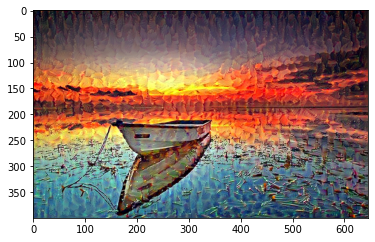

Image saved as:  my_result_at_iteration_0.png
Iteration 0 completed in 4s
Start of iteration:  1
Current loss:  619894000.0
Image saved as:  my_result_at_iteration_0.png
Iteration 1 completed in 4s
Start of iteration:  2
Current loss:  395560100.0
Image saved as:  my_result_at_iteration_0.png
Iteration 2 completed in 4s
Start of iteration:  3
Current loss:  299460380.0
Image saved as:  my_result_at_iteration_0.png
Iteration 3 completed in 4s
Start of iteration:  4
Current loss:  248205600.0
Image saved as:  my_result_at_iteration_0.png
Iteration 4 completed in 4s
Start of iteration:  5
Current loss:  216216450.0
Image saved as:  my_result_at_iteration_0.png
Iteration 5 completed in 4s
Start of iteration:  6
Current loss:  193605470.0
Image saved as:  my_result_at_iteration_0.png
Iteration 6 completed in 4s
Start of iteration:  7
Current loss:  171017980.0
Image saved as:  my_result_at_iteration_0.png
Iteration 7 completed in 4s
Start of iteration:  8
Current loss:  156585200.0
Image sa

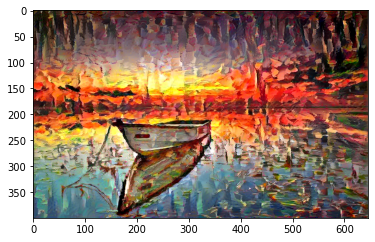

Image saved as:  my_result_at_iteration_100.png
Iteration 100 completed in 5s
Start of iteration:  101
Current loss:  37593868.0
Image saved as:  my_result_at_iteration_100.png
Iteration 101 completed in 4s
Start of iteration:  102
Current loss:  37490492.0
Image saved as:  my_result_at_iteration_100.png
Iteration 102 completed in 4s
Start of iteration:  103
Current loss:  37379744.0
Image saved as:  my_result_at_iteration_100.png
Iteration 103 completed in 4s
Start of iteration:  104
Current loss:  37274280.0
Image saved as:  my_result_at_iteration_100.png
Iteration 104 completed in 4s
Start of iteration:  105
Current loss:  37129900.0
Image saved as:  my_result_at_iteration_100.png
Iteration 105 completed in 4s
Start of iteration:  106
Current loss:  36988056.0
Image saved as:  my_result_at_iteration_100.png
Iteration 106 completed in 4s
Start of iteration:  107
Current loss:  36886236.0
Image saved as:  my_result_at_iteration_100.png
Iteration 107 completed in 4s
Start of iteration:

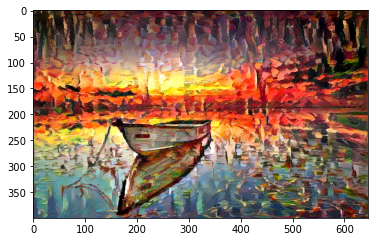

Image saved as:  my_result_at_iteration_200.png
Iteration 200 completed in 5s
Start of iteration:  201
Current loss:  29417802.0
Image saved as:  my_result_at_iteration_200.png
Iteration 201 completed in 4s
Start of iteration:  202
Current loss:  29377664.0
Image saved as:  my_result_at_iteration_200.png
Iteration 202 completed in 4s
Start of iteration:  203
Current loss:  29326234.0
Image saved as:  my_result_at_iteration_200.png
Iteration 203 completed in 4s
Start of iteration:  204
Current loss:  29279598.0
Image saved as:  my_result_at_iteration_200.png
Iteration 204 completed in 4s
Start of iteration:  205
Current loss:  29235964.0
Image saved as:  my_result_at_iteration_200.png
Iteration 205 completed in 5s
Start of iteration:  206
Current loss:  29198126.0
Image saved as:  my_result_at_iteration_200.png
Iteration 206 completed in 4s
Start of iteration:  207
Current loss:  29153166.0
Image saved as:  my_result_at_iteration_200.png
Iteration 207 completed in 4s
Start of iteration:

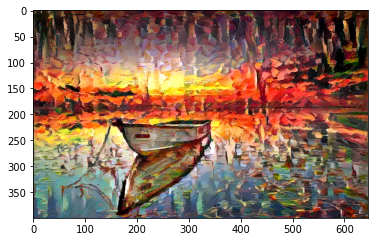

Image saved as:  my_result_at_iteration_300.png
Iteration 300 completed in 5s
Start of iteration:  301
Current loss:  26222256.0
Image saved as:  my_result_at_iteration_300.png
Iteration 301 completed in 4s
Start of iteration:  302
Current loss:  26201656.0
Image saved as:  my_result_at_iteration_300.png
Iteration 302 completed in 4s
Start of iteration:  303
Current loss:  26184012.0
Image saved as:  my_result_at_iteration_300.png
Iteration 303 completed in 4s
Start of iteration:  304
Current loss:  26164382.0
Image saved as:  my_result_at_iteration_300.png
Iteration 304 completed in 4s
Start of iteration:  305
Current loss:  26145806.0
Image saved as:  my_result_at_iteration_300.png
Iteration 305 completed in 4s
Start of iteration:  306
Current loss:  26111552.0
Image saved as:  my_result_at_iteration_300.png
Iteration 306 completed in 4s
Start of iteration:  307
Current loss:  26077918.0
Image saved as:  my_result_at_iteration_300.png
Iteration 307 completed in 5s
Start of iteration:

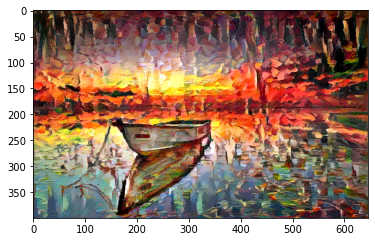

Image saved as:  my_result_at_iteration_400.png
Iteration 400 completed in 5s
Start of iteration:  401
Current loss:  24324578.0
Image saved as:  my_result_at_iteration_400.png
Iteration 401 completed in 4s
Start of iteration:  402
Current loss:  24312152.0
Image saved as:  my_result_at_iteration_400.png
Iteration 402 completed in 5s
Start of iteration:  403
Current loss:  24300354.0
Image saved as:  my_result_at_iteration_400.png
Iteration 403 completed in 4s
Start of iteration:  404
Current loss:  24288784.0
Image saved as:  my_result_at_iteration_400.png
Iteration 404 completed in 4s
Start of iteration:  405
Current loss:  24278202.0
Image saved as:  my_result_at_iteration_400.png
Iteration 405 completed in 4s
Start of iteration:  406
Current loss:  24264638.0
Image saved as:  my_result_at_iteration_400.png
Iteration 406 completed in 4s
Start of iteration:  407
Current loss:  24251218.0
Image saved as:  my_result_at_iteration_400.png
Iteration 407 completed in 4s
Start of iteration:

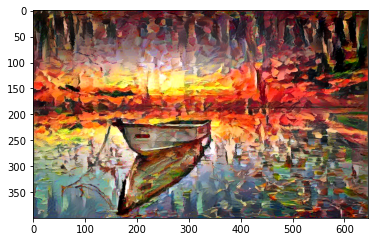

Image saved as:  my_result_at_iteration_500.png
Iteration 500 completed in 5s
Start of iteration:  501
Current loss:  23134552.0
Image saved as:  my_result_at_iteration_500.png
Iteration 501 completed in 4s
Start of iteration:  502
Current loss:  23123728.0
Image saved as:  my_result_at_iteration_500.png
Iteration 502 completed in 4s
Start of iteration:  503
Current loss:  23108820.0
Image saved as:  my_result_at_iteration_500.png
Iteration 503 completed in 4s
Start of iteration:  504
Current loss:  23093782.0
Image saved as:  my_result_at_iteration_500.png
Iteration 504 completed in 4s
Start of iteration:  505
Current loss:  23078724.0
Image saved as:  my_result_at_iteration_500.png
Iteration 505 completed in 4s
Start of iteration:  506
Current loss:  23062938.0
Image saved as:  my_result_at_iteration_500.png
Iteration 506 completed in 4s
Start of iteration:  507
Current loss:  23051232.0
Image saved as:  my_result_at_iteration_500.png
Iteration 507 completed in 4s
Start of iteration:

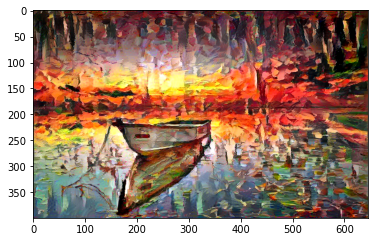

Image saved as:  my_result_at_iteration_600.png
Iteration 600 completed in 5s
Start of iteration:  601
Current loss:  22191620.0
Image saved as:  my_result_at_iteration_600.png
Iteration 601 completed in 4s
Start of iteration:  602
Current loss:  22184608.0
Image saved as:  my_result_at_iteration_600.png
Iteration 602 completed in 4s
Start of iteration:  603
Current loss:  22178450.0
Image saved as:  my_result_at_iteration_600.png
Iteration 603 completed in 4s
Start of iteration:  604
Current loss:  22171658.0
Image saved as:  my_result_at_iteration_600.png
Iteration 604 completed in 4s
Start of iteration:  605
Current loss:  22165708.0
Image saved as:  my_result_at_iteration_600.png
Iteration 605 completed in 4s
Start of iteration:  606
Current loss:  22159278.0
Image saved as:  my_result_at_iteration_600.png
Iteration 606 completed in 4s
Start of iteration:  607
Current loss:  22147404.0
Image saved as:  my_result_at_iteration_600.png
Iteration 607 completed in 4s
Start of iteration:

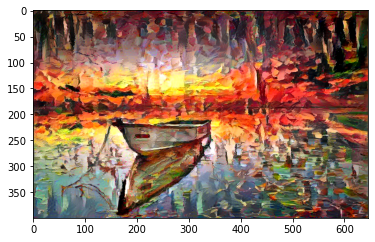

Image saved as:  my_result_at_iteration_700.png
Iteration 700 completed in 5s
Start of iteration:  701
Current loss:  21466930.0
Image saved as:  my_result_at_iteration_700.png
Iteration 701 completed in 4s
Start of iteration:  702
Current loss:  21457034.0
Image saved as:  my_result_at_iteration_700.png
Iteration 702 completed in 4s
Start of iteration:  703
Current loss:  21444208.0
Image saved as:  my_result_at_iteration_700.png
Iteration 703 completed in 4s
Start of iteration:  704
Current loss:  21438750.0
Image saved as:  my_result_at_iteration_700.png
Iteration 704 completed in 4s
Start of iteration:  705
Current loss:  21431388.0
Image saved as:  my_result_at_iteration_700.png
Iteration 705 completed in 4s
Start of iteration:  706
Current loss:  21424840.0
Image saved as:  my_result_at_iteration_700.png
Iteration 706 completed in 4s
Start of iteration:  707
Current loss:  21417974.0
Image saved as:  my_result_at_iteration_700.png
Iteration 707 completed in 4s
Start of iteration:

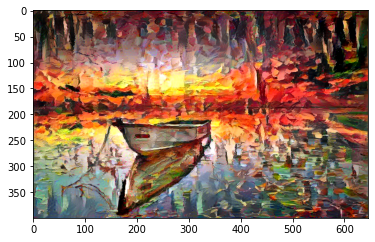

Image saved as:  my_result_at_iteration_800.png
Iteration 800 completed in 5s
Start of iteration:  801
Current loss:  20865578.0
Image saved as:  my_result_at_iteration_800.png
Iteration 801 completed in 4s
Start of iteration:  802
Current loss:  20859760.0
Image saved as:  my_result_at_iteration_800.png
Iteration 802 completed in 4s
Start of iteration:  803
Current loss:  20855584.0
Image saved as:  my_result_at_iteration_800.png
Iteration 803 completed in 4s
Start of iteration:  804
Current loss:  20851370.0
Image saved as:  my_result_at_iteration_800.png
Iteration 804 completed in 4s
Start of iteration:  805
Current loss:  20846980.0
Image saved as:  my_result_at_iteration_800.png
Iteration 805 completed in 4s
Start of iteration:  806
Current loss:  20843026.0
Image saved as:  my_result_at_iteration_800.png
Iteration 806 completed in 4s
Start of iteration:  807
Current loss:  20837614.0
Image saved as:  my_result_at_iteration_800.png
Iteration 807 completed in 4s
Start of iteration:

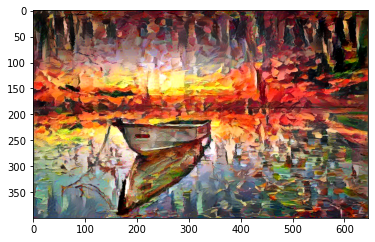

Image saved as:  my_result_at_iteration_900.png
Iteration 900 completed in 5s
Start of iteration:  901
Current loss:  20362268.0
Image saved as:  my_result_at_iteration_900.png
Iteration 901 completed in 4s
Start of iteration:  902
Current loss:  20358748.0
Image saved as:  my_result_at_iteration_900.png
Iteration 902 completed in 4s
Start of iteration:  903
Current loss:  20354694.0
Image saved as:  my_result_at_iteration_900.png
Iteration 903 completed in 4s
Start of iteration:  904
Current loss:  20351146.0
Image saved as:  my_result_at_iteration_900.png
Iteration 904 completed in 4s
Start of iteration:  905
Current loss:  20347328.0
Image saved as:  my_result_at_iteration_900.png
Iteration 905 completed in 4s
Start of iteration:  906
Current loss:  20343472.0
Image saved as:  my_result_at_iteration_900.png
Iteration 906 completed in 4s
Start of iteration:  907
Current loss:  20338314.0
Image saved as:  my_result_at_iteration_900.png
Iteration 907 completed in 4s
Start of iteration:

In [40]:
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.keras.preprocessing.image import save_img
import time
result_prefix = 'my_result'
evaluator = Evaluator()

iterations = 1000
x = preprocess_image(target_image_path)
for i in range(iterations):
  print('Start of iteration: ', i)
  start_time = time.time()
  x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                   fprime=evaluator.grads, maxfun=20)
  print('Current loss: ', min_val)                                  

  if i % 100 == 0:
    img = deprocess_image(x.copy())
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    show_image(fname)
  end_time = time.time()
  print('Image saved as: ', fname)
  print('Iteration %d completed in %ds' % (i, end_time - start_time))
  


Base Image


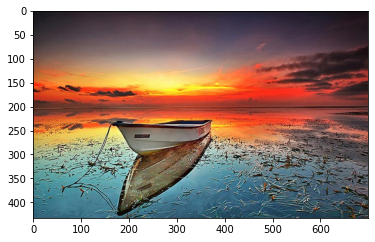

Style reference


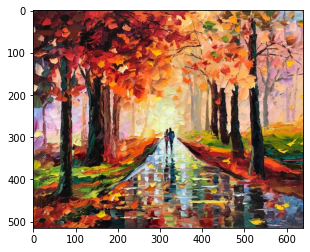

Combine Image


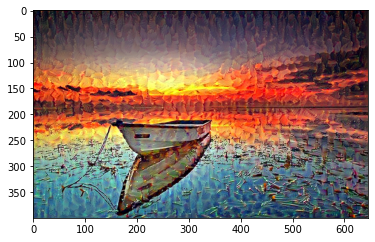

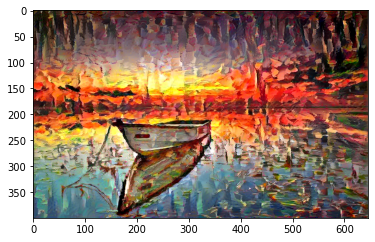

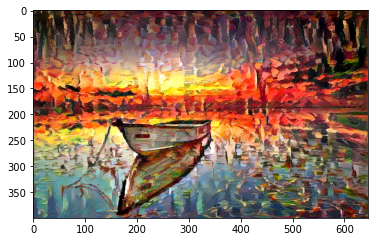

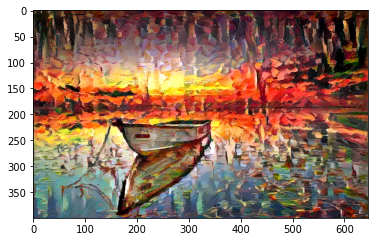

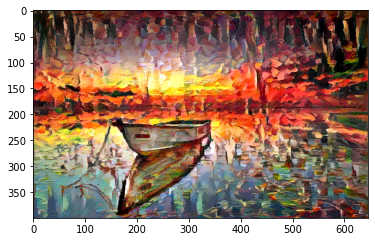

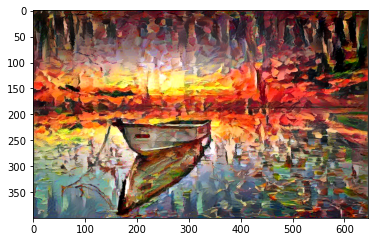

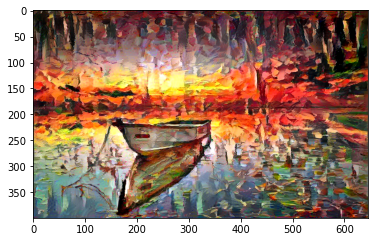

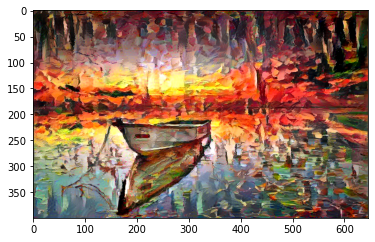

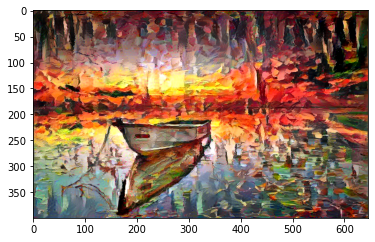

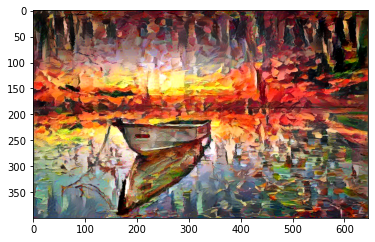

In [44]:
print('Base Image')
show_image('boat.jpg')
print('Style reference')
show_image('beautifulnight.jpg')
print('Combine Image')
for i in range(10):
  show_image('my_result_at_iteration_%d.png' % (100 * i))